In [30]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Add, Input, Activation
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

In [31]:
metadata_test = pd.read_csv('test_metadata.csv')
metadata_val = pd.read_csv('val_metadata.csv')
new_metadata_train = pd.read_csv('train_metadata.csv')

In [32]:
# double checking which values should be cleaned or filled
missing_values = metadata_val['clin_size_long_diam_mm'].isna().sum()
print(f"Missing values in 'clin_size_long_diam_mm' for meta val data: {missing_values}")

missing_values = metadata_val['age_approx'].isna().sum()
print(f"Missing values in 'age_approx' for meta val data: {missing_values}")

missing_values = metadata_val['sex'].isna().sum()
print(f"Missing values in 'sex' for new meta val data: {missing_values}")

missing_values = metadata_val['diagnosis_1'].isna().sum()
print(f"Missing values in 'diagnosis_1' for meta val data: {missing_values}")

print(f'values in meta val data: {len(new_metadata_train)}')

Missing values in 'clin_size_long_diam_mm' for meta val data: 18574
Missing values in 'age_approx' for meta val data: 945
Missing values in 'sex' for new meta val data: 2760
Missing values in 'diagnosis_1' for meta val data: 0
values in meta val data: 349531


In [33]:
missing_values = new_metadata_train['clin_size_long_diam_mm'].isna().sum()
print(f"Missing values in 'clin_size_long_diam_mm' for new meta train data: {missing_values}")

missing_values = new_metadata_train['age_approx'].isna().sum()
print(f"Missing values in 'age_approx' for new meta train data: {missing_values}")

missing_values = new_metadata_train['sex'].isna().sum()
print(f"Missing values in 'sex' for new meta train data: {missing_values}")

missing_values = new_metadata_train['diagnosis_1'].isna().sum()
print(f"Missing values in 'diagnosis_1' for new meta train data: {missing_values}")

print(f'values in new meta train data: {len(new_metadata_train)}')

Missing values in 'clin_size_long_diam_mm' for new meta train data: 65517
Missing values in 'age_approx' for new meta train data: 3398
Missing values in 'sex' for new meta train data: 9608
Missing values in 'diagnosis_1' for new meta train data: 0
values in new meta train data: 349531


In [34]:
#filling in missing values for clin_size_long_diam_mm

meanTestVal = metadata_test['clin_size_long_diam_mm'].mean()
metadata_test['clin_size_long_diam_mm'] = metadata_test['clin_size_long_diam_mm'].fillna(meanTestVal)

meanTrainVal = metadata_train['clin_size_long_diam_mm'].mean()
metadata_train['clin_size_long_diam_mm'] = metadata_train['clin_size_long_diam_mm'].fillna(meanTrainVal)

meanValidationVal = metadata_val['clin_size_long_diam_mm'].mean()
metadata_val['clin_size_long_diam_mm'] = metadata_val['clin_size_long_diam_mm'].fillna(meanValidationVal)

meanTrainVal = new_metadata_train['clin_size_long_diam_mm'].mean()
new_metadata_train['clin_size_long_diam_mm'] = new_metadata_train['clin_size_long_diam_mm'].fillna(meanTrainVal)
new_metadata_train.head()

,age_approx,clin_size_long_diam_mm,sex,diagnosis_1
0,45.0,2.60,1.0,0.0
1,70.0,4.32,0.0,0.0
2,40.0,2.62,0.0,0.0
3,65.0,6.20,1.0,0.0
4,85.0,5.07,1.0,0.0


In [35]:
metadata_test.head()

,age_approx,clin_size_long_diam_mm,sex,diagnosis_1
0,55.0,2.88,1.0,0.0
1,50.0,2.96,1.0,0.0
2,55.0,4.97,0.0,0.0
3,50.0,3.84,0.0,0.0
4,75.0,2.82,0.0,0.0


In [36]:
# drop rows with missing values

metadata_test.dropna(subset=['age_approx', 'sex', 'diagnosis_1'], inplace=True)

metadata_train.dropna(subset=['age_approx', 'sex', 'diagnosis_1'], inplace=True)

metadata_val.dropna(subset=['age_approx', 'sex', 'diagnosis_1'], inplace=True)

new_metadata_train.dropna(subset=['age_approx', 'sex', 'diagnosis_1'], inplace=True)

In [37]:
missing_values = new_metadata_train['clin_size_long_diam_mm'].isna().sum()
print(f"Missing values in 'clin_size_long_diam_mm' for new meta train data: {missing_values}")

missing_values = new_metadata_train['age_approx'].isna().sum()
print(f"Missing values in 'age_approx' for new meta train data: {missing_values}")

missing_values = new_metadata_train['sex'].isna().sum()
print(f"Missing values in 'sex' for new meta train data: {missing_values}")

missing_values = new_metadata_train['diagnosis_1'].isna().sum()
print(f"Missing values in 'diagnosis_1' for new meta train data: {missing_values}")

print(f'values in new meta train data: {len(new_metadata_train)}')

Missing values in 'clin_size_long_diam_mm' for new meta train data: 0
Missing values in 'age_approx' for new meta train data: 0
Missing values in 'sex' for new meta train data: 0
Missing values in 'diagnosis_1' for new meta train data: 0
values in new meta train data: 338456


In [38]:
#fill in missing values dsak;adjkf;a

In [39]:
metadata_test.head()

,age_approx,clin_size_long_diam_mm,sex,diagnosis_1
0,55.0,2.88,1.0,0.0
1,50.0,2.96,1.0,0.0
2,55.0,4.97,0.0,0.0
3,50.0,3.84,0.0,0.0
4,75.0,2.82,0.0,0.0


In [40]:
metadata_train.head()

,age_approx,clin_size_long_diam_mm,sex,diagnosis_1
0,45.0,2.60,1.0,0.0
1,70.0,4.32,0.0,0.0
2,40.0,2.62,0.0,0.0
3,65.0,6.20,1.0,0.0
4,85.0,5.07,1.0,0.0


In [41]:
metadata_val.head()

,age_approx,clin_size_long_diam_mm,sex,diagnosis_1
0,40.0,3.720000,1.0,0.0
1,15.0,3.992361,1.0,0.0
2,40.0,2.660000,1.0,0.0
3,55.0,3.260000,0.0,0.0
4,80.0,2.570000,1.0,0.0


In [42]:
metadata_X_test = metadata_test.iloc[:, :-1]
metadata_Y_test = metadata_test.iloc[:, -1]
metadata_X_val = metadata_val.iloc[:, :-1]
metadata_Y_val = metadata_val.iloc[:, -1]

new_metadata_X_train = new_metadata_train.iloc[:, :-1]
new_metadata_Y_train = new_metadata_train.iloc[:, -1]

In [43]:
new_metadata_X_train.head()

,age_approx,clin_size_long_diam_mm,sex
0,45.0,2.60,1.0
1,70.0,4.32,0.0
2,40.0,2.62,0.0
3,65.0,6.20,1.0
4,85.0,5.07,1.0


In [44]:
new_metadata_Y_train.head()

,diagnosis_1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [18]:
numberOfColumns = 3 #age, diameter, sex
inputs = Input(shape=(numberOfColumns,))

x = Dense(64, activation="relu")(inputs)  # First Dense layer
x = Dense(32, activation="relu")(x)       # Second Dense layer

# residual block
residual_input = x # Save input for the residual connection

# dense layers inside the residual block
xRes = Dense(16, activation="relu")(x)
xRes = Dense(16, activation="relu")(xRes)

# ensures residual input will match same dimensions as the output of our residual block
if residual_input.shape[-1] != xRes.shape[-1]:
    residual_input = Dense(16)(residual_input)


# adding the residual input to the output
xRes = Add()([xRes, residual_input])

# skip connection
skip_connection = Dense(16)(inputs)

xSkip = Add()([xRes, skip_connection])  # combine residual block output with skip connection


# final layers
x = Dense(16, activation="relu")(xSkip)
x = Dense(16, activation="relu")(x)

output = Dense(1, activation="sigmoid")(x)

In [19]:
model = Model(inputs=inputs, outputs=output)

In [20]:
model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        272 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16)        │          0 │ dense_3[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │         64 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16)        │          0 │ add[0][0],        │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        272 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        272 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         17 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

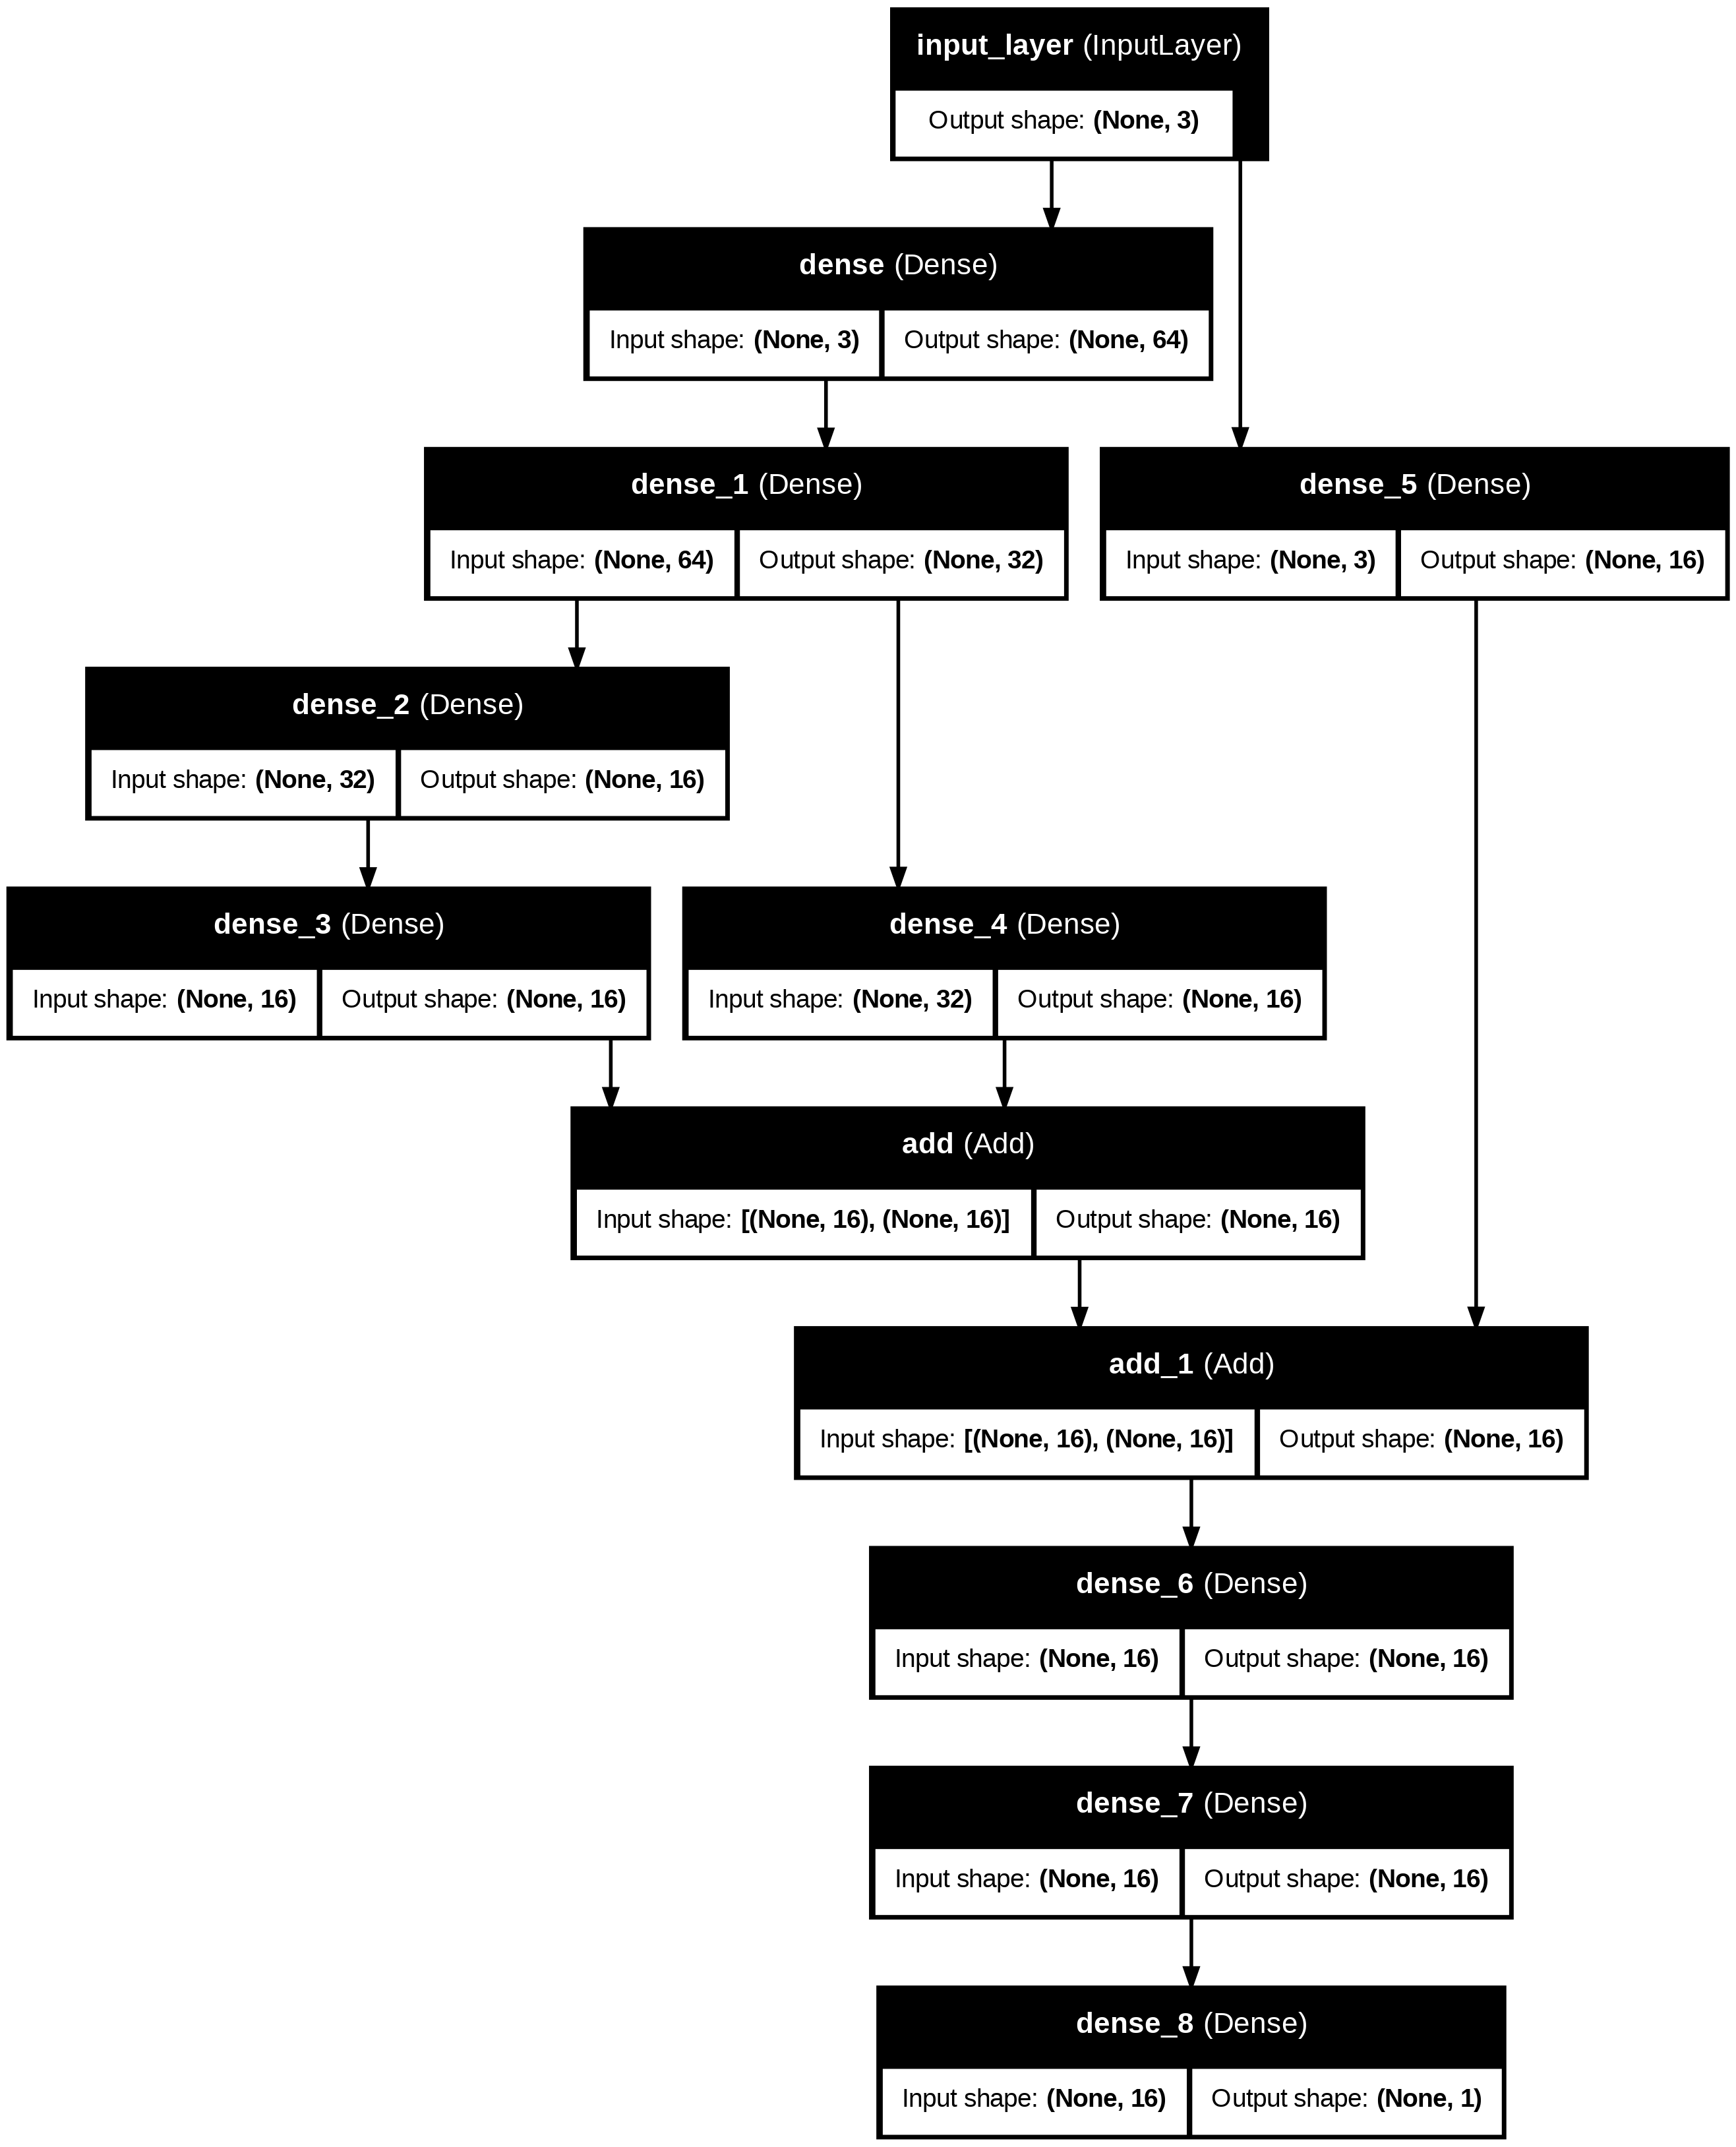

In [22]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [24]:
es = EarlyStopping(monitor='val_accuracy',
                           patience=50,
                           restore_best_weights=True,
                           verbose=1) # early stopping



checkpoint = ModelCheckpoint('best_MLP_model.keras', monitor='val_loss', save_best_only=True)

In [25]:
networkHistory = model.fit(new_metadata_X_train, new_metadata_Y_train,
                    validation_data=(metadata_X_val, metadata_Y_val),
                    epochs=800,
                    batch_size=128,
                    callbacks=[es, checkpoint],
                    verbose=2)

Epoch 1/800
2645/2645 - 13s - 5ms/step - accuracy: 0.9624 - loss: 0.1641 - val_accuracy: 0.9625 - val_loss: 0.1515
Epoch 2/800
2645/2645 - 9s - 3ms/step - accuracy: 0.9625 - loss: 0.1506 - val_accuracy: 0.9625 - val_loss: 0.1444
Epoch 3/800
2645/2645 - 9s - 4ms/step - accuracy: 0.9623 - loss: 0.1375 - val_accuracy: 0.9624 - val_loss: 0.1295
Epoch 4/800
2645/2645 - 9s - 4ms/step - accuracy: 0.9624 - loss: 0.1262 - val_accuracy: 0.9625 - val_loss: 0.1195
Epoch 5/800
2645/2645 - 11s - 4ms/step - accuracy: 0.9624 - loss: 0.1197 - val_accuracy: 0.9616 - val_loss: 0.1211
Epoch 6/800
2645/2645 - 8s - 3ms/step - accuracy: 0.9624 - loss: 0.1165 - val_accuracy: 0.9624 - val_loss: 0.1124
Epoch 7/800
2645/2645 - 7s - 3ms/step - accuracy: 0.9624 - loss: 0.1146 - val_accuracy: 0.9625 - val_loss: 0.1172
Epoch 8/800
2645/2645 - 11s - 4ms/step - accuracy: 0.9625 - loss: 0.1125 - val_accuracy: 0.9625 - val_loss: 0.1136
Epoch 9/800
2645/2645 - 10s - 4ms/step - accuracy: 0.9624 - loss: 0.1123 - val_accura

In [26]:
# evaluate on the validation set
test_loss, test_acc = model.evaluate(metadata_X_test, metadata_Y_test, verbose=1)

1511/1511 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9634 - loss: 0.0981


In [27]:
num_params = model.count_params()

# final results
final_train_loss = networkHistory.history['loss'][-1]

# print the results
print(f"Number of parameters: {num_params}")
print(f"Final training loss: {final_train_loss}")
print(f"Final test loss: {test_loss}")

Number of parameters: 4289
Final training loss: 0.09827860444784164
Final test loss: 0.09688188880681992
